# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.16KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

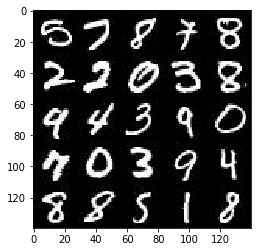

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

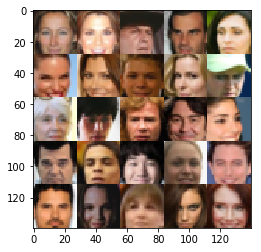

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [193]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [194]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', use_bias=False)
        bn1 = tf.layers.batch_normalization(x1, training=True)        
        relu1 = tf.nn.relu(bn1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', use_bias=False)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.relu(bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', use_bias=False)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.relu(bn3)
        
        flat = tf.reshape(relu3, (-1,4*4*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [195]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #alpha = 0.2
    # TODO: Implement Function
    #if is_train == True:
    with tf.variable_scope('generator', reuse=not is_train):
            
        x1 = tf.layers.dense(z, 7*7*512, activation = None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
            
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 2, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28,28))
        out = tf.tanh(logits)
    """
    if is_train == False:
        with tf.variable_scope('generator', reuse=True):

            x1 = tf.layers.dense(z, 7*7*512, activation = None)
            x1 = tf.reshape(x1, (-1, 7, 7, 512))
            x1 = tf.layers.batch_normalization(x1, training=is_train)
            x1 = tf.nn.relu(x1)
            
            x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', use_bias=False)
            x2 = tf.layers.batch_normalization(x2, training=is_train)
            x2 = tf.nn.relu(x2)
        
            #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', use_bias=False)
            #x3 = tf.layers.batch_normalization(x3, training=is_train)
            #x3 = tf.maximum(alpha * x3, x3)

            logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 2, strides=2, padding='same')
        
            out = tf.tanh(logits)
            """
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [196]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [197]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [198]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [210]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    
    losses = []
    
    steps = 0
    print_every = 10
    show_every = 100
    im_width = data_shape[1]
    im_height = data_shape[2]
    im_filters = data_shape[3]
    out_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(im_width, im_height, im_filters, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #print(batch_images.shape)
                #print(batch_images.dtype)
                steps += 1
                #batch_images_1 = get_batches(batch_size)[batch_images*batch_size]
                #create the 'white noise' input as a matrix of random values from -1 to 1
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim)) 
                
                #run the optimizers
                #first the discriminator
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                #then the generator
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                if steps % print_every == 0:
                    #get the losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    #save the losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 15, input_z, out_dim, data_image_mode)

    #with open('samples.pk1', 'wb') as f:
    #    pkl.dump(samples, f)
        
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0107... Generator Loss: 6.1437
Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 5.4761
Epoch 1/2... Discriminator Loss: 0.0114... Generator Loss: 5.1447
Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 6.2419
Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 6.2746
Epoch 1/2... Discriminator Loss: 0.0026... Generator Loss: 6.3945
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.7709
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.3969
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 7.8355
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 7.4875


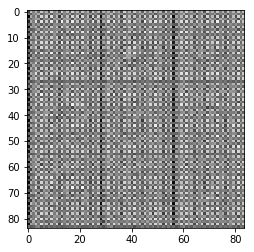

Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 7.5309
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 20.4010
Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 12.4210
Epoch 1/2... Discriminator Loss: 8.0188... Generator Loss: 0.0008
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 2.2694
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.0049
Epoch 1/2... Discriminator Loss: 0.4623... Generator Loss: 2.0336
Epoch 1/2... Discriminator Loss: 0.7187... Generator Loss: 2.3072
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 1.5789
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 4.3883


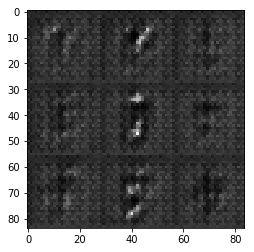

Epoch 1/2... Discriminator Loss: 0.3605... Generator Loss: 2.7118
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 3.8530
Epoch 1/2... Discriminator Loss: 0.4476... Generator Loss: 1.5266
Epoch 1/2... Discriminator Loss: 0.2841... Generator Loss: 3.1114
Epoch 1/2... Discriminator Loss: 0.2596... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 0.2199... Generator Loss: 2.1597
Epoch 1/2... Discriminator Loss: 0.1358... Generator Loss: 2.6872
Epoch 1/2... Discriminator Loss: 3.0675... Generator Loss: 8.9614
Epoch 1/2... Discriminator Loss: 0.2056... Generator Loss: 2.7700
Epoch 1/2... Discriminator Loss: 0.1603... Generator Loss: 3.1890


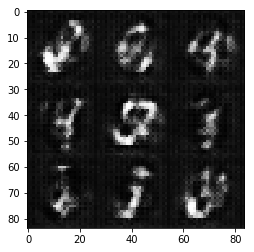

Epoch 1/2... Discriminator Loss: 0.1082... Generator Loss: 3.0684
Epoch 1/2... Discriminator Loss: 0.0866... Generator Loss: 3.1698
Epoch 1/2... Discriminator Loss: 0.0466... Generator Loss: 3.9950
Epoch 1/2... Discriminator Loss: 0.1071... Generator Loss: 2.9183
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 2.3417
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.4692
Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 1.5085
Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 2.2521... Generator Loss: 0.1578


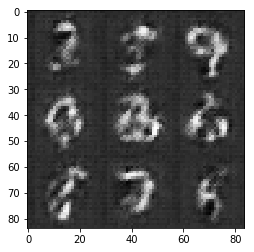

Epoch 1/2... Discriminator Loss: 0.4083... Generator Loss: 3.0294
Epoch 1/2... Discriminator Loss: 0.1512... Generator Loss: 2.7835
Epoch 1/2... Discriminator Loss: 0.3100... Generator Loss: 1.6470
Epoch 1/2... Discriminator Loss: 0.1829... Generator Loss: 3.8279
Epoch 1/2... Discriminator Loss: 2.1520... Generator Loss: 0.1774
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 1.5982
Epoch 2/2... Discriminator Loss: 0.2099... Generator Loss: 2.6028
Epoch 2/2... Discriminator Loss: 0.1571... Generator Loss: 3.7492
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 6.6764
Epoch 2/2... Discriminator Loss: 0.2517... Generator Loss: 1.9778


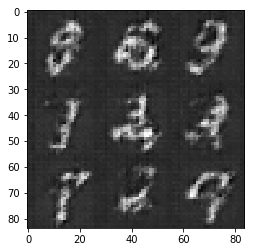

Epoch 2/2... Discriminator Loss: 0.1811... Generator Loss: 2.4173
Epoch 2/2... Discriminator Loss: 0.1681... Generator Loss: 2.3605
Epoch 2/2... Discriminator Loss: 0.1941... Generator Loss: 4.2295
Epoch 2/2... Discriminator Loss: 0.2531... Generator Loss: 4.8782
Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 4.7099
Epoch 2/2... Discriminator Loss: 0.4612... Generator Loss: 1.5808
Epoch 2/2... Discriminator Loss: 0.4547... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 0.2738... Generator Loss: 1.9139
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 0.4596... Generator Loss: 1.4169


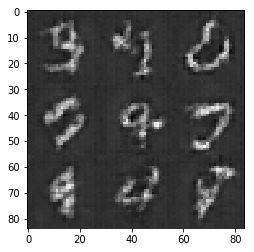

Epoch 2/2... Discriminator Loss: 0.3275... Generator Loss: 1.7364
Epoch 2/2... Discriminator Loss: 0.2654... Generator Loss: 1.9500
Epoch 2/2... Discriminator Loss: 0.2931... Generator Loss: 1.7914
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 1.4061
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.7021
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 0.6284... Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 0.3843... Generator Loss: 1.7666
Epoch 2/2... Discriminator Loss: 0.2418... Generator Loss: 2.3840


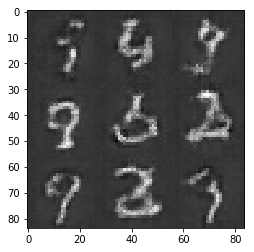

Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 4.6899
Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 1.8448
Epoch 2/2... Discriminator Loss: 0.2500... Generator Loss: 2.0978
Epoch 2/2... Discriminator Loss: 0.2363... Generator Loss: 1.9842
Epoch 2/2... Discriminator Loss: 0.1101... Generator Loss: 2.8939
Epoch 2/2... Discriminator Loss: 0.1915... Generator Loss: 4.5575
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 2.8854
Epoch 2/2... Discriminator Loss: 0.3415... Generator Loss: 1.6271
Epoch 2/2... Discriminator Loss: 0.2346... Generator Loss: 2.5030
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 4.1379


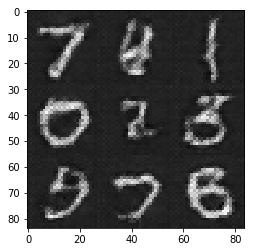

Epoch 2/2... Discriminator Loss: 0.3196... Generator Loss: 1.9140
Epoch 2/2... Discriminator Loss: 0.1227... Generator Loss: 2.9667
Epoch 2/2... Discriminator Loss: 0.1828... Generator Loss: 2.3878
Epoch 2/2... Discriminator Loss: 0.1345... Generator Loss: 2.5633
Epoch 2/2... Discriminator Loss: 0.0645... Generator Loss: 3.6470
Epoch 2/2... Discriminator Loss: 3.5689... Generator Loss: 8.2934
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 0.4626... Generator Loss: 1.7034
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 3.9055


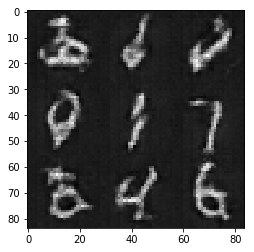

Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.4590
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 3.3056
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 4.0126


NameError: name 'pkl' is not defined

In [211]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [78]:
print(mnist_dataset.shape)

(60000, 28, 28, 1)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1141... Generator Loss: 8.3408
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 5.4777
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 21.8444
Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 12.7218
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 2.4375
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 3.3396
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7601


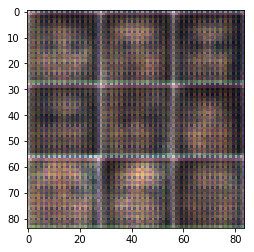

Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 2.7817... Generator Loss: 0.1030
Epoch 1/1... Discriminator Loss: 1.9717... Generator Loss: 0.2235
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 2.6411
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 3.5953
Epoch 1/1... Discriminator Loss: 0.2509... Generator Loss: 4.3008
Epoch 1/1... Discriminator Loss: 1.7078... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.5632


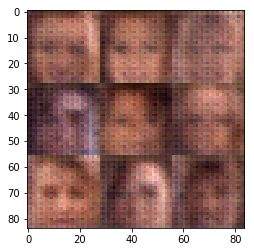

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.2167
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 3.2575... Generator Loss: 0.0536
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.1499


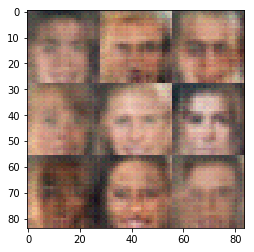

Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.5548


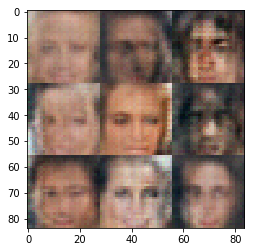

Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.6633
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.7288


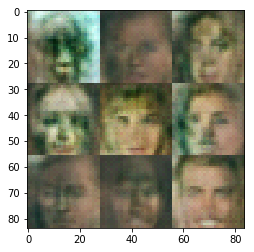

Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 2.1231
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.3071
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.3281
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.4665


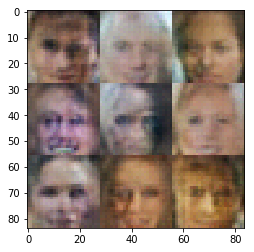

Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.7667
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.7193


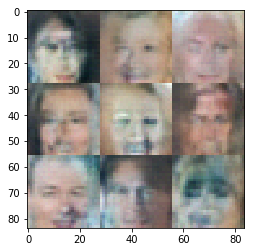

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 2.3015
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.5935


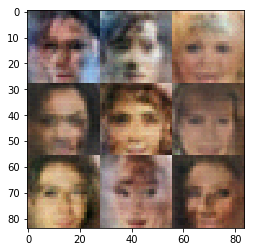

Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.8404... Generator Loss: 0.2198
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 3.5635
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.5279
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8635


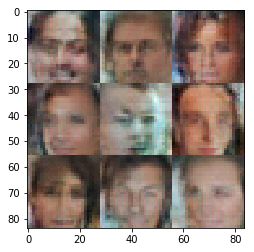

Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.0126
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.3095
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 2.2732
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 2.1732


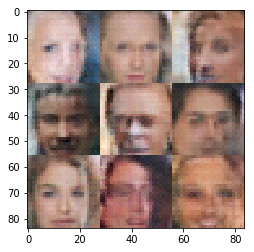

Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 2.1475
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 2.7111
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 2.6694
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.5827


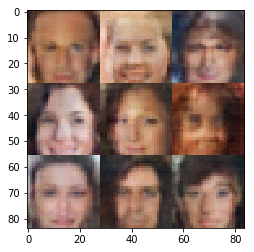

Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.4554


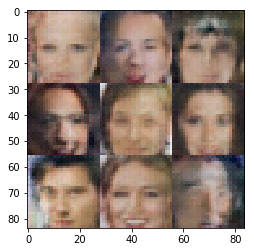

Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 2.2473
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 2.3991... Generator Loss: 0.1271


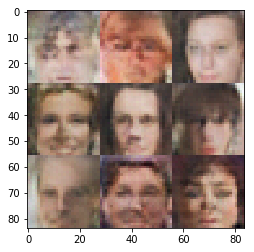

Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.4324


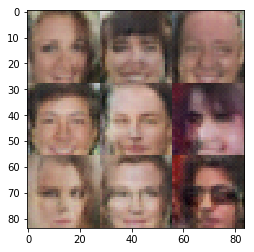

Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.4370


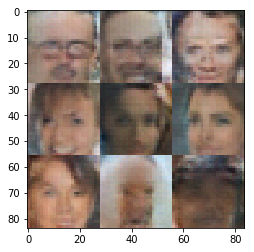

Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 2.2915
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.5592


NameError: name 'pkl' is not defined

In [212]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.